1. Make predictions based on majority voting
2. Reduce overfitting by drawing random combinations of the training set with repetition
3. Build powerful models from weak learners that learn from their mistakes

In [1]:
from scipy.special import comb
import math

def ensemble_error(n_classifier, error):
    k_start = math.ceil(n_classifier / 2.0)
    probs = [comb(n_classifier, k) *
             error ** k *
             (1 - error) ** (n_classifier - k)
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)

ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

In [2]:
import numpy as np
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error) 
              for error in error_range]
import matplotlib.pyplot as plt

plt.plot(error_range, ens_errors,
         label='Ensemble error',
         linewidth=2)
plt.plot(error_range, error_range,
         linestyle='--', label='Base error',
         linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid()
plt.show()
#plt.imshow()

<Figure size 640x480 with 1 Axes>

## Implementing a simple majority vote classifier

In [3]:
import numpy as np
np.argmax(np.bincount([0, 0, 1],
                      weights=[0.2, 0.2, 0.6]))

1

In [4]:
ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4, 0.6]])
p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
print(p)
print(np.argmax(p))

[0.58 0.42]
0


In [5]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


/home/biowar1337/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [6]:
'''
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator,
                             ClassifierMixin):
    """ A majority vote ensemble classifier
    
    Parameters
    -----------
    classifiers : array-like, shape = [n_classifiers]
        Different classifiers for the ensemble
        
    vote : str, {'classlabel', 'probability'}
        Default: 'classlabel'
        If 'classlabel' the prediction is based on
        the argmax of class labels. Else if 
        'probability', the argmax of the sum of probabilities
        is used to predict the class label
        (recommended for calibrated classifiers).
        
    weights : array-like, shape = [n_classifiers]
        Optional, default: None
        If  a list of `int` or `float` values are
        provided, the classifiers are weighted by
        importance; Uses uniform weights if `weights=None`.
        
    """
    def __init__(self, classifiers, 
                 vote='classlabel', weights=None):
        self.classifiers_ = classifiers
        self.named_classifiers = {key: value for
                                  key, value in 
                                  _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        """Fit classifiers
        
        Parameters
        -----------
        X : {array-like, sparse matrix},
            shape = [n_samples, n_features]
            Matrix of training samples.
            
        y : array-like, shape = [n_samples]
            Vector of target class labels.
            
        Returns
        --------
        self : object
        
        """
        # Use LabelEncoder to ensure class labels start
        # with 0, which is important for np.argmax
        # call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers_:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
        
    def predict(self, X):
        """ Predict class labels for X.
        Parameters
        ----------
        X : {array-like, sparse matrix},
            Shape = [n_samples, n_features]
            Matrix of training samples.
        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X),axis=1)
        else: # 'classlabel' vote
            # Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                        for clf in
                                        self.classifiers_]).T
            
            maj_vote = np.apply_along_axis(
                        lambda x:
                        np.argmax(np.bincount(x,
                                                weights=self.weights)),
                        axis=1,
                        arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote   
    
    def predict_proba(self, X):
        """ Predict class probabilities for X.
        Parameters
        ----------
        X : {array-like, sparse matrix},
            shape = [n_samples, n_features]
            Training vectors, where n_samples is
            the number of samples and
            n_features is the number of features.
        Returns
        ----------
        avg_proba : array-like,
            shape = [n_samples, n_classes]
            Weighted average probability for
            each class per sample.
        """
        probas = np.asarray([clf.predict_proba(X)
                            for clf in self.classifiers_])
        avg_proba = np.average(probas,
                                axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier,
                        self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in\
                six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(
                    step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out
'''

'\nfrom sklearn.base import BaseEstimator\nfrom sklearn.base import ClassifierMixin\nfrom sklearn.preprocessing import LabelEncoder\nfrom sklearn.externals import six\nfrom sklearn.base import clone\nfrom sklearn.pipeline import _name_estimators\nimport numpy as np\nimport operator\n\nclass MajorityVoteClassifier(BaseEstimator,\n                             ClassifierMixin):\n    """ A majority vote ensemble classifier\n    \n    Parameters\n    -----------\n    classifiers : array-like, shape = [n_classifiers]\n        Different classifiers for the ensemble\n        \n    vote : str, {\'classlabel\', \'probability\'}\n        Default: \'classlabel\'\n        If \'classlabel\' the prediction is based on\n        the argmax of class labels. Else if \n        \'probability\', the argmax of the sum of probabilities\n        is used to predict the class label\n        (recommended for calibrated classifiers).\n        \n    weights : array-like, shape = [n_classifiers]\n        Optional, d

In [7]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
iris = datasets.load_iris()
X, y = iris.data[50:, [1,2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np
clf1 = LogisticRegression(penalty='l2', 
                          C=0.001,
                          random_state=0)
clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')
pipe1 = Pipeline([['sc', StandardScaler()],
                 ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])
clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']
print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

10-fold cross validation:



/home/biowar1337/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]


/home/biowar1337/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/biowar1337/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/biowar1337/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/biowar1337/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/biowar1337/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will 

In [10]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority Voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, 
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

NameError: name 'MajorityVoteClassifier' is not defined

In [1]:
from sklearn.metrics import roc_curve, auc
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


NameError: name 'all_clf' is not defined

In [ ]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=2, ncols=2,
                        sharex='col',
                        sharey='row',
                        figsize=(7,5))
for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
                                  X_train_std[y_train==0, 1],
                                  c='blue', 
                                  marker='^',
                                  s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
                                  X_train_std[y_train==1, 1],
                                  c='red',
                                  marker='o',
                                  s=50)
    axarr[idx[0], idx[1]].set_title(tt)
    
plt.text(-3.5, -4.5,
         s='Petal length [standardized]',
         ha='center', va='center',
         fontsize=12, rotation=90)
plt.show()

In [2]:
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol',
                   'Malic acid', 'Ash',
                   'Alcalinity of ash',
                   'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols',
                   'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines',
                   'Proline']
df_wine = df_wine[df_wine['Class label'] != 1]
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'Hue']].values

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=1)

In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=None,
                              random_state=1)
bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500,
                        max_samples=1.0,
                        max_features=1.0,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=1)

In [10]:
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))


Decision tree train/test accuracies 1.000/0.833


In [11]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('Bagging train/test accuracies %.3f/%.3f' % (bag_train, bag_test))

Bagging train/test accuracies 1.000/0.896


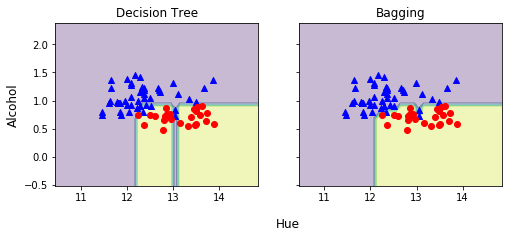

In [12]:
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2,
                        sharex='col',
                        sharey='row',
                        figsize=(8,3))
for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Decision Tree', 'Bagging']):
    clf.fit(X_train, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0],
                       X_train[y_train==0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0],
                       X_train[y_train==1, 1],
                       c='red', marker='o')
    axarr[idx].set_title(tt)
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2,
         s='Hue',
        ha='center', va='center', fontsize=12)
plt.show()

In [29]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=1,
                              random_state=0)

ada = AdaBoostClassifier(base_estimator=None,
                         n_estimators=500,
                         learning_rate=0.1,
                         random_state=0)

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

Decision tree train/test accuracies 0.845/0.854


In [30]:
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)

print('AdaBoost train/test accuracies %.3f/%.3f' % (ada_train, ada_test))

AdaBoost train/test accuracies 1.000/0.875


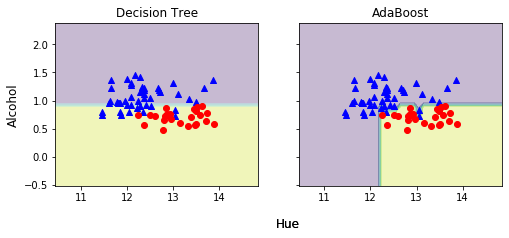

In [32]:
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                               np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(1, 2,
                        sharex='col',
                        sharey='row',
                        figsize=(8, 3))
for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Decision Tree', 'AdaBoost']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0],
                       X_train[y_train==0, 1],
                       c='blue',
                       marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0],
                       X_train[y_train==1, 1],
                       c='red',
                       marker='o')
    axarr[idx].set_title(tt)
    axarr[0].set_ylabel('Alcohol', fontsize=12)
    plt.text(10.2, -1.2,
             s='Hue',
             ha='center',
             va='center',
             fontsize=12)
plt.show()